# LSTM in Numpy


In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from module import Module

In [3]:
# Random seed
np.random.seed(420)

In [4]:
# Sigmoid helper function
def sigmoid(x):
    return 1 / (1 + np.exp(-1 * x))

# Derivative sigmoid helper function
def dsigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x))

In [5]:
# Open the training data and save some important variables. If you want to train on your own text, just change the .txt file in the data variable.
#data = open('shakespeare.txt', 'r').read()
data = open('nescio.txt', 'r').read()
chars = list(set(data))
data_size = len(data)
vocab_size = len(chars)

In [6]:
print(f'Data set is length {data_size}')
print(f'Vocab set is length {vocab_size}')

Data set is length 201884
Vocab set is length 88


In [7]:
# Simple character embedding
char_to_idx = {char:i for i, char in enumerate(chars)}
idx_to_char = {i:char for i, char in enumerate(chars)}

In [8]:
# hyperparameters
hidden_size = 100
seq_length = 25
learning_rate = 1e-1
epochs = 10

In [59]:
class LSTM(Module):
    
    def __init__(self, seq_length, hidden_sz, vocab_sz):
        self.weight_params = ['Whf', 'Wxf', 'Whi', 'Wxi', 'Whc', 'Wxc'
                             , 'Who', 'Wxo', 'Why', 'Bf', 'Bi', 'Bc'
                             , 'Bo', 'By']    
        self.hidden_params = ['hs', 'ct', 'ho', 'hc', 'hi', 'hf']
        
        super().__init__(seq_length, hidden_sz, vocab_sz)

    def forward(self, xs, targets):
        """
        Forward pass LSTM
        """
        
        y_preds = {}
        
        self.loss = 0
        
        for i in range(len(xs)):
            # Vectorize the input
            x = xs[i]
            x_vec = np.zeros((self.vocab_sz, 1)) 
            x_vec[x] = 1
            
            
            # Calculate new hidden and cell state
            self.hidden['hf'][i] = np.dot(self.params['Whf']['weight'], self.hidden['hs'][i - 1]) \
                                   + np.dot(self.params['Wxf']['weight'], x_vec) \
                                   + self.params['Bf']['bias']
            
            self.hidden['hi'][i] = np.dot(self.params['Whi']['weight'], self.hidden['hs'][i - 1]) \
                                   + np.dot(self.params['Wxi']['weight'], x_vec) \
                                   + self.params['Bi']['bias']
            
            self.hidden['hc'][i] = np.dot(self.params['Whc']['weight'], self.hidden['hs'][i - 1]) \
                                   + np.dot(self.params['Wxc']['weight'], x_vec) \
                                   + self.params['Bc']['bias']
            
            self.hidden['ho'][i] = np.dot(self.params['Who']['weight'], self.hidden['hs'][i - 1]) \
                                   + np.dot(self.params['Wxo']['weight'], x_vec) \
                                   + self.params['Bo']['bias']
            
            
            f_t = sigmoid(self.hidden['hf'][i])
            i_t = sigmoid(self.hidden['hi'][i])
            cwave_t = np.tanh(self.hidden['hc'][i])
            o_t = sigmoid(self.hidden['ho'][i])
            
            self.hidden['ct'][i] = f_t * self.hidden['ct'][i - 1] + i_t * cwave_t
            self.hidden['hs'][i] = o_t * np.tanh(self.hidden['ct'][i])
            
            # Predict y
            y_preds[i] = np.dot(self.params['Why']['weight'], self.hidden['hs'][i]) \
                         + self.params['By']['bias']
            
            self.sm_ps[i] = np.exp(y_preds[i]) / np.sum(np.exp(y_preds[i])) # Softmax probability
            self.loss += -np.log(self.sm_ps[i][targets[i], 0]) # Negative loss likelyhood
            
        self.hidden['ct'][-1] = self.hidden['ct'][len(xs) - 1]
        self.hidden['hs'][-1] = self.hidden['hs'][len(xs) - 1]
        
    def backward(self, xs, targets):
        """
        Backward pass for LSTM
        """
        
        # Initialize gradients
        self.gradient_params= self.init_grads()
        
        # Start with an empty next layer for the cell state and hidden state
        dhnext = np.zeros_like(self.hidden['hs'][0])
        dcnext = np.zeros_like(self.hidden['ct'][0])
        
        # Loop over inputs and calculate gradients
        for i in reversed(range(len(xs))):
            # One hot encoding
            x = xs[i]
            x_vec = np.zeros((vocab_size, 1))
            x_vec[x] = 1
            
            dy = np.copy(self.sm_ps[i])
            dy[targets[i]] -= 1 # backprop into y. see http://cs231n.github.io/neural-networks-case-study/#grad if confused here
            
            self.params['By']['grad'] += dy
            self.params['Why']['grad'] += np.dot(dy, self.hidden['hs'][i].T)
            # h branches to ouput, and next layer. Therefore, we need the gradient of next layer is added
            dh = np.dot(self.params['Why']['weight'].T, dy) + dhnext 
            
            # Calculations for o
            do = dh * np.tanh(self.hidden['ct'][i]) # Weet dit niet zeker
            do = dsigmoid(self.hidden['ho'][i]) * do
            
            self.params['Wxo']['grad'] += np.dot(do, x_vec.T)
            self.params['Who']['grad'] += np.dot(do, self.hidden['hs'][i-1].T)
            self.params['Bo']['grad'] += do
            
            # Calculations for dc
            dc= dh * sigmoid(self.hidden['ho'][i]) 
            dc = (1-np.square(np.tanh(self.hidden['ct'][i]))) * dc #Weet dit ook niet zeker
            dc = dc + dcnext
            
            # Calculation dcwave
            dcwave_t = sigmoid(self.hidden['hi'][i]) * dc
            # C branches to next layer, therefore we need the gradient of that layer added.
            dcwave_t = dcwave_t * (1-np.square(np.tanh(self.hidden['hc'][i])))
            
            self.params['Wxc']['grad'] += np.dot(dcwave_t, x_vec.T)
            self.params['Whc']['grad'] += np.dot(dcwave_t, self.hidden['hs'][i-1].T)
            self.params['Bc']['grad'] += dcwave_t
            
            # Calculating di
            di = sigmoid(self.hidden['hc'][i]) * dc
            di = di * dsigmoid(self.hidden['hi'][i])
            
            self.params['Wxi']['grad'] += np.dot(di, x_vec.T)
            self.params['Whi']['grad'] += np.dot(di, self.hidden['hs'][i-1].T)
            self.params['Bi']['grad'] += di
            
            #Calculating df
            df = self.hidden['ct'][i-1] * dc
            df = dsigmoid(self.hidden['hf'][i]) * df
            
            self.params['Wxf']['grad'] += np.dot(df, x_vec.T)
            self.params['Whf']['grad'] += np.dot(df, self.hidden['hs'][i-1].T)
            self.params['Bf']['grad'] += df
            
        # Clip to prevent exploding gradients
        for dparam in self.params.keys():
            np.clip(self.params[dparam]['grad'], -5, 5, out=self.params[dparam]['grad'])
        
    def predict(self, start, n):
        """
        Predict a sequence of text based on a starting string.
        """
        seed_idx = char_to_idx[start[-1]]
        x = np.zeros((self.vocab_sz, 1))
        x[seed_idx] = 1
        
        txt = [ch for ch in start]
        
        idxes = []
        
        hs = self.hidden['hs'][-1]
        ct = self.hidden['ct'][-1]
        
        for i in range(n):
            # Calculate new hidden and cell state
            hf = np.dot(self.params['Whf']['weight'], hs) \
                                   + np.dot(self.params['Wxf']['weight'], x) \
                                   + self.params['Bf']['bias']

            hi = np.dot(self.params['Whi']['weight'], hs) \
                                   + np.dot(self.params['Wxi']['weight'], x) \
                                   + self.params['Bi']['bias']

            hc = np.dot(self.params['Whc']['weight'], hs) \
                                   + np.dot(self.params['Wxc']['weight'], x) \
                                   + self.params['Bc']['bias']

            ho = np.dot(self.params['Who']['weight'], hs) \
                                   + np.dot(self.params['Wxo']['weight'], x) \
                                   + self.params['Bo']['bias']


            f_t = sigmoid(hf)
            i_t = sigmoid(hi)
            cwave_t = np.tanh(hc)
            o_t = sigmoid(ho)

            ct = f_t * ct + i_t * cwave_t
            hs = o_t * np.tanh(ct)

            # Predict y
            y = np.dot(self.params['Why']['weight'], hs) \
                         + self.params['By']['bias']
            
            sm_p = np.exp(y) / np.sum(np.exp(y)) # Softmax probability
            # Determine character based on weighted probability
            idx = np.random.choice(range(self.vocab_sz), p=sm_p.ravel())
            idxes.append(idx)
            
            # Save X for next iteration
            x = np.zeros((self.vocab_sz,1 ))
            x[idx] = 1
            
        prediction = [idx_to_char[idx] for idx in idxes]
        
        txt += prediction
        
        return txt

In [60]:
model = LSTM(seq_length, hidden_size, vocab_size)

In [61]:
model.params

{'Whf': {'size': (100, 100),
  'weight': array([[ 0.01340367,  0.005418  , -0.00194326, ...,  0.00422032,
          -0.00503635,  0.00468907],
         [ 0.01020123,  0.00761376,  0.00855668, ..., -0.00357507,
           0.00398505,  0.00599429],
         [ 0.00491151, -0.00267479, -0.00409303, ...,  0.01184285,
          -0.01858956,  0.02052839],
         ...,
         [ 0.00397735,  0.0057269 , -0.00516185, ...,  0.01482739,
           0.00452045,  0.01040128],
         [ 0.00913654,  0.00450024,  0.00659015, ..., -0.00767838,
          -0.01070829, -0.00817688],
         [-0.00079445, -0.00257792, -0.00375077, ...,  0.00415348,
           0.0043862 , -0.00119602]])},
 'Wxf': {'size': (100, 88),
  'weight': array([[-0.01853347, -0.00449898, -0.0007995 , ..., -0.00250447,
          -0.0156546 ,  0.01083167],
         [ 0.00266871,  0.00166099, -0.00856653, ...,  0.00897382,
           0.00146813, -0.00188852],
         [ 0.01814609, -0.00660111,  0.00651297, ..., -0.01524703,
       

In [62]:
xs = [char_to_idx[ch] for ch in data[0:5]]
targets = [char_to_idx[ch] for ch in data[1:6]]
model.forward(xs, targets)

In [63]:
model.backward(xs, targets)

In [64]:
model.train(data, 'Adagrad', learning_rate, 1)

Epoch 1: 0 / 8075: 111.93341849444748
Epoch 1: 1000 / 8075: 75.75929370538876
Epoch 1: 2000 / 8075: 59.59590309329555
Epoch 1: 3000 / 8075: 52.43971337015008
Epoch 1: 4000 / 8075: 49.90041393840289
Epoch 1: 5000 / 8075: 49.052490385149035
Epoch 1: 6000 / 8075: 47.68241805949845
Epoch 1: 7000 / 8075: 46.65093367060193
Epoch 1: 8000 / 8075: 46.33798556307158


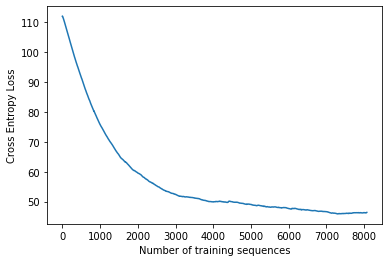

In [65]:
model.plot_losses()

In [68]:
prediction = model.predict('Gefeliciteerd', 50)
print(''.join(prediction))

Gefeliciteerding en
stontende bustig de hoomd. Ambing
van get e
